# MadMiner particle physics tutorial

# Part 4a: Limit setting

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In part 4a of this tutorial we will use the networks trained in step 3a and 3b to calculate the expected limits on our theory parameters.

## 0. Preparations

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import six
import logging
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

from madminer.limits import AsymptoticLimits
from madminer.sampling import SampleAugmenter
from madminer import sampling


In [2]:
# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        print("Deactivating logging output for", key)
        logging.getLogger(key).setLevel(logging.WARNING)

Deactivating logging output for concurrent.futures
Deactivating logging output for concurrent
Deactivating logging output for asyncio
Deactivating logging output for prompt_toolkit
Deactivating logging output for parso.python.diff
Deactivating logging output for parso.python
Deactivating logging output for parso
Deactivating logging output for parso.cache
Deactivating logging output for tornado.access
Deactivating logging output for tornado
Deactivating logging output for tornado.application
Deactivating logging output for tornado.general
Deactivating logging output for IPKernelApp
Deactivating logging output for matplotlib
Deactivating logging output for matplotlib.ticker
Deactivating logging output for matplotlib.font_manager
Deactivating logging output for matplotlib.dviread
Deactivating logging output for matplotlib.text
Deactivating logging output for matplotlib.texmanager
Deactivating logging output for matplotlib.blocking_input
Deactivating logging output for matplotlib._layoutb

## 1. Preparations

In the end, what we care about are not plots of the log likelihood ratio, but limits on parameters. But at least under some asymptotic assumptions, these are directly related. MadMiner makes it easy to calculate p-values in the asymptotic limit with the `AsymptoticLimits` class in the `madminer.limits`: 

In [3]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')
# limits = AsymptoticLimits('data/delphes_data_shuffled.h5')

16:45 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
16:45 madminer.analysis    INFO    Found 2 parameters
16:45 madminer.analysis    INFO    Did not find nuisance parameters
16:45 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
16:45 madminer.analysis    INFO    Found 3 observables
16:45 madminer.analysis    INFO    Found 15117 events
16:45 madminer.analysis    INFO      10004 signal events sampled from benchmark sm
16:45 madminer.analysis    INFO      1080 signal events sampled from benchmark w
16:45 madminer.analysis    INFO      1207 signal events sampled from benchmark neg_w
16:45 madminer.analysis    INFO      1399 signal events sampled from benchmark ww
16:45 madminer.analysis    INFO      1427 signal events sampled from benchmark neg_ww
16:45 madminer.analysis    INFO    Found morphing setup with 6 components
16:45 madminer.analysis    INFO    Did not find nuisance morphing setup


This class provids two high-level functions:
- `AsymptoticLimits.observed_limits()` lets us calculate p-values on a parameter grid for some observed events, and
- `AsymptoticLimits.expected_limits()` lets us calculate expected p-values on a parameter grid based on all data in the MadMiner file.

First we have to define the parameter grid on which we evaluate the p-values.

In [4]:
grid_ranges = [(-20., 20.), (-20., 20.)]
grid_resolutions = [25, 25]

What luminosity (in inverse pb) are we talking about?

In [5]:
lumi = 10000.

In [6]:
p_values = {}
mle = {}

## 2. Expected limits based on histogram

First, as a baseline, let us calculate the expected limits based on a simple jet pT histogram. Right now, there are not a lot of option for this function; MadMiner even calculates the binning automatically. (We will add more functionality!)

The keyword `include_xsec` determines whether we include information from the total rate or just use the shapes. Since we don't model backgrounds and systematics in this tutorial, the rate information is unrealistically large, so we leave it out here.

In [7]:
theta_grid, p_values_expected_histo, best_fit_expected_histo, _, _, histos = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["Histogram"] = p_values_expected_histo
mle["Histogram"] = best_fit_expected_histo

10:37 madminer.limits      INFO    Generating Asimov data
10:37 madminer.limits      INFO    Expected events: 2.072791638419519
10:37 madminer.limits      INFO    Setting up standard summary statistics
10:37 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using 25 bins each, or 25 in total.
10:37 madminer.limits      INFO    Determining fixed adaptive histogram binning for theta = [0. 0.]
10:37 madminer.analysis    WARNING Requested 100000 events, but only 12094 available
10:37 madminer.analysis    WARNING Requested 100000 events, but only 12094 available
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 10% to 50% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 10% to 50% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 10% to 50% 

With `mode="rate"`, we could calculate limits based on only the rate -- but again, since the rate is extremely powerful when backgrounds and systematics are not taken into account, we don't do that in this tutorial.

Let's visualize the likelihood estimated with these histograms:

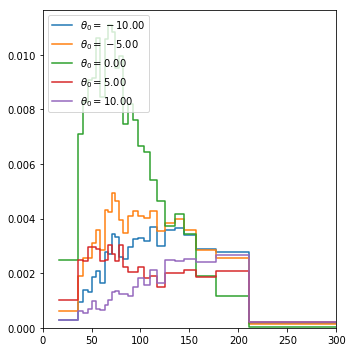

In [8]:
indices = [12 + i * 25 for i in [6,9,12,15,18]]

def plot_histo(edges, histo, color=None, label=None):
    edges_ = np.copy(edges)
    edges_ = np.repeat(edges_, 2)[1:-1]
    histo_ = np.repeat(histo, 2)
    plt.plot(edges_, histo_, color=color, lw=1.5, ls="-", label=label)

plt.figure(figsize=(5,5))
for i in indices:
    plot_histo(histos[i].edges[0], histos[i].histo, label=r"$\theta_0 = {:.2f}$".format(theta_grid[i,0]))
plt.legend(loc="upper left")
plt.xlim(0.,300.)
plt.ylim(0., None)
plt.tight_layout()
plt.show()


## 3. Expected limits based on ratio estimators

Next, `mode="ml"` allows us to calculate limits based on any `ParamterizedRatioEstimator` instance like the ALICES estimator trained above:

In [9]:
theta_grid, p_values_expected_alices, best_fit_expected_alices, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES"] = p_values_expected_alices
mle["ALICES"] = best_fit_expected_alices

10:37 madminer.limits      INFO    Generating Asimov data
10:37 madminer.limits      INFO    Expected events: 2.072791638419519
10:37 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
10:37 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
10:37 madminer.limits      INFO    Calculating p-values


## 4. Expected limits based on score estimators

To get p-values from a SALLY estimator, we have to use histograms of the estimated score:

In [7]:
theta_grid, p_values_expected_sally, best_fit_expected_sally, _, _, histos = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SALLY"] = p_values_expected_sally
mle["SALLY"] = best_fit_expected_sally

16:45 madminer.limits      INFO    Generating Asimov data
16:45 madminer.limits      INFO    Expected events: 2.072791638419519
16:45 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
16:45 madminer.ml          INFO    Loading model from models/sally
16:45 madminer.ml          INFO    Starting score evaluation
16:45 root                 INFO    Keeping nuisance parameter score
16:45 madminer.limits      INFO    Creating histograms of 2 summary statistics. Using 8 bins each, or 64 in total.
16:45 madminer.limits      INFO    Determining fixed adaptive histogram binning for theta = [0. 0.]
16:45 madminer.analysis    WARNING Requested 100000 events, but only 12094 available
16:45 madminer.ml          INFO    Starting score evaluation
16:45 root                 INFO    Keeping nuisance parameter score
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 4% to 100% with media

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 23%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 23%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 21%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 20%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 20%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 17%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 17%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 17%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 19%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 21%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 21%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 22%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 23%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 25%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 23%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 24%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 21%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 20%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 16%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 16%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 18%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 19%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 19%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 20%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 22%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 23%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 24%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 25%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 10% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 10% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 26

16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 26%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 27%.
16:45 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 100% with median 27%.

Let's have a look at the underlying 2D histograms:

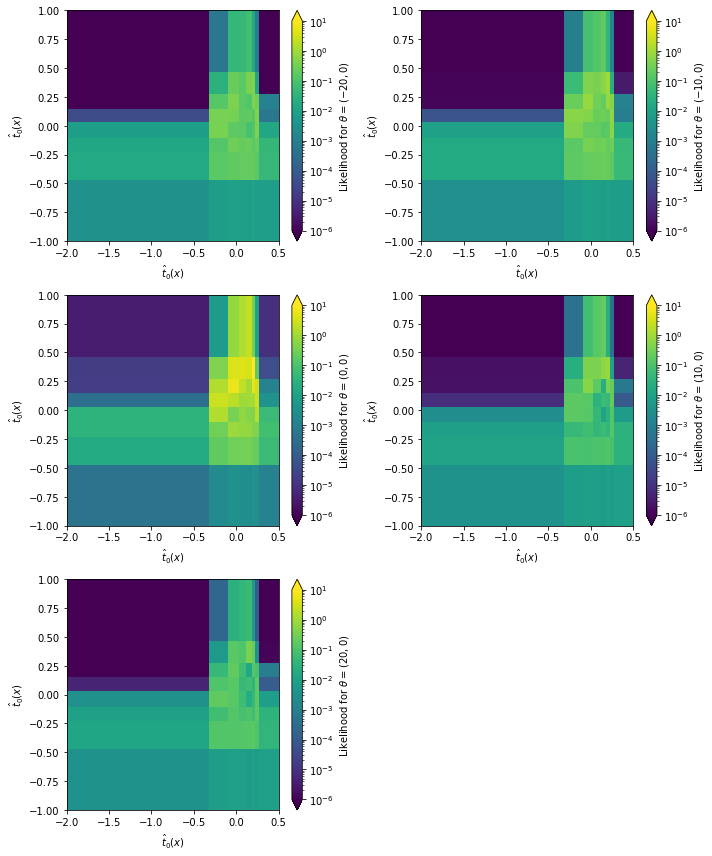

In [23]:
indices = [12 + i * 25 for i in [0,6,12,18,24]]
n_cols = 2
n_rows = (len(indices)-1)//n_cols + 1

fig = plt.figure(figsize=(n_cols*5., n_rows*4.))

for panel, i in enumerate(indices):
    ax = plt.subplot(n_rows, n_cols, panel+1)
    edges, counts = histos[i].edges, histos[i].histo
    
    pcm = ax.pcolormesh(
        edges[0], edges[1], counts,
        cmap="viridis", norm = matplotlib.colors.LogNorm(1.e-6, 10.)
    )
    cbar = fig.colorbar(pcm, ax=ax, extend='both')
    
    plt.xlim(-2.,0.5)
    plt.ylim(-1.,1.)
    plt.xlabel(r'$\hat{t}_0(x)$')
    plt.ylabel(r'$\hat{t}_0(x)$')
    cbar.set_label(r'Likelihood for $\theta = ({:.0f}, {:.0f})$'.format(theta_grid[i,0], theta_grid[i,1]))
plt.tight_layout()
plt.show()
    

We can also use the "SALLINO" strategy, which constructs 1D histogram of `theta * score` at every parameter point on the grid:

In [11]:
theta_grid, p_values_expected_sallino, best_fit_expected_sallino, _, _, histos = limits.expected_limits(
    mode="sallino",
    model_file='models/sally',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SALLINO"] = p_values_expected_sallino
mle["SALLINO"] = best_fit_expected_sallino

10:37 madminer.limits      INFO    Generating Asimov data
10:37 madminer.limits      INFO    Expected events: 2.072791638419519
10:37 madminer.limits      WARNING The SALLINO and adaptive SALLY methods require the reference point, but the argument thetaref was not provided. Assuming thetaref = [0. 0.].
10:37 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
10:37 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using 25 bins each, or 25 in total.
10:37 madminer.analysis    WARNING Requested 100000 events, but only 12094 available
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 79% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 80% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertaint

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 82% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 86% with median 17%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 96% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 93% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 5% to 93% with median 15%.
10:3

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 4% to 89% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 4% to 96% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 4% to 81% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 98% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 89% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 76% with median 15%.
10:37

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 54% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 53% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 54% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 54% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 54% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 60% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 61% with median 13%.
10:37 

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 62% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 66% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 68% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 62% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 65% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 78% with median 13%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 83% with median 13%.
10:37 

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 64% with median 13%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 60% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 63% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 61% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 61% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 59% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 60% with median 15%.
10:37 

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 54% with median 14%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 54% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 54% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 57% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 63% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 73% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 91% with median 15%.
10:37 

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 96% with median 21%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 21%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 19%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 6% to 100% with median 22%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 20%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 21%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 100% with median 19%.


10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 99% with median 17%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 87% with median 18%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 18%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 97% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 84% with median 18%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 96% with median 15%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 94% with median 17%.
10:37

10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 85% with median 16%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 91% with median 17%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 98% with median 17%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 8% to 100% with median 17%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 7% to 89% with median 18%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 84% with median 19%.
10:37 madminer.utils.histo WARNING Large statistical uncertainties in histogram! Relative uncertainties range from 9% to 87% with median 18%.
10:37

We can actually visualize the histograms here:

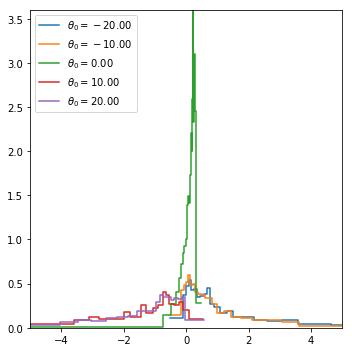

In [12]:
indices = [12 + i * 25 for i in [0,6,12,18,24]]

def plot_histo(edges, histo, color=None, label=None):
    edges_ = np.copy(edges)
    edges_ = np.repeat(edges_, 2)[1:-1]
    histo_ = np.repeat(histo, 2)
    plt.plot(edges_, histo_, color=color, lw=1.5, ls="-", label=label)

plt.figure(figsize=(5,5))
for i in indices:
    plot_histo(histos[i].edges[0], histos[i].histo, label=r"$\theta_0 = {:.2f}$".format(theta_grid[i,0]))
plt.legend(loc="upper left")
plt.xlim(-5.,5.)
plt.ylim(0., 3.6)
plt.tight_layout()
plt.show()


## 5. Expected limits based on likelihood estimators

In [13]:
theta_grid, p_values_expected_scandal, best_fit_expected_scandal, _, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/scandal',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["SCANDAL"] = p_values_expected_scandal
mle["SCANDAL"] = best_fit_expected_scandal

10:37 madminer.limits      INFO    Generating Asimov data
10:37 madminer.limits      INFO    Expected events: 2.072791638419519
10:37 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
10:37 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
10:38 madminer.limits      INFO    Calculating p-values


## 6. Toy signal

In addition to these expected limits (based on the SM), let us inject a mock signal. We first generate the data:

In [14]:
sampler = SampleAugmenter('data/lhe_data_shuffled.h5')
x_observed, _, _ = sampler.sample_test(
    theta=sampling.morphing_point([10.,10.]),
    n_samples=100,
    folder=None,
    filename=None,
)

10:38 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
10:38 madminer.analysis    INFO    Found 2 parameters
10:38 madminer.analysis    INFO    Did not find nuisance parameters
10:38 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
10:38 madminer.analysis    INFO    Found 3 observables
10:38 madminer.analysis    INFO    Found 15117 events
10:38 madminer.analysis    INFO      10004 signal events sampled from benchmark sm
10:38 madminer.analysis    INFO      1080 signal events sampled from benchmark w
10:38 madminer.analysis    INFO      1207 signal events sampled from benchmark neg_w
10:38 madminer.analysis    INFO      1399 signal events sampled from benchmark ww
10:38 madminer.analysis    INFO      1427 signal events sampled from benchmark neg_ww
10:38 madminer.analysis    INFO    Found morphing setup with 6 components
10:38 madminer.analysis    INFO    Did not find nuisance morphing setup
10:38 madminer.sampling    INFO    Extracting evalua

In [15]:
_, p_values_observed, best_fit_observed, _, _, _ = limits.observed_limits(
    x_observed=x_observed,
    mode="ml",
    model_file='models/alices',
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
)

p_values["ALICES signal"] = p_values_observed
mle["ALICES signal"] = best_fit_observed

10:38 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
10:38 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
10:38 madminer.limits      INFO    Calculating p-values


## 7. Plot

Let's plot the results:

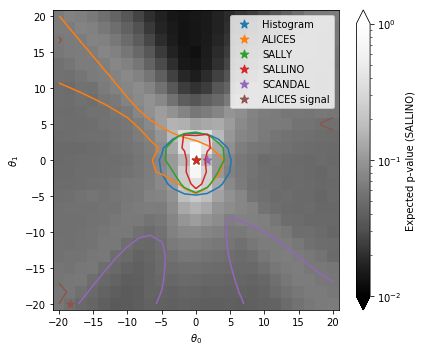

In [18]:
show = "SALLINO"

bin_size = (grid_ranges[0][1] - grid_ranges[0][0])/(grid_resolutions[0] - 1)
edges = np.linspace(grid_ranges[0][0] - bin_size/2, grid_ranges[0][1] + bin_size/2, grid_resolutions[0] + 1)
centers = np.linspace(grid_ranges[0][0], grid_ranges[0][1], grid_resolutions[0])

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cmin, cmax = 1.e-2, 1.

pcm = ax.pcolormesh(
    edges, edges, p_values[show].reshape((grid_resolutions[0], grid_resolutions[1])),
    norm=matplotlib.colors.LogNorm(vmin=cmin, vmax=cmax),
    cmap='Greys_r'
)
cbar = fig.colorbar(pcm, ax=ax, extend='both')

for i, (label, p_value) in enumerate(six.iteritems(p_values)):
    plt.contour(
        centers, centers, p_value.reshape((grid_resolutions[0], grid_resolutions[1])),
        levels=[0.32],
        linestyles='-', colors='C{}'.format(i)
    )
    plt.scatter(
        theta_grid[mle[label]][0], theta_grid[mle[label]][1],
        s=80., color='C{}'.format(i), marker='*',
        label=label
    )

plt.legend()

plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Expected p-value ({})'.format(show))

plt.tight_layout()
plt.show()
